In [1]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import wandb
import tensorflow as tf
import os
import chardet
import pandas as pd
from transformers import TrOCRProcessor

AUTOTUNE = tf.data.AUTOTUNE
# weight decay values to try
# [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# 0
wandb.init( 
    project="democtatii-TrOCR_test_v1.0-small-local",
    config={
        "batch_size": 16,
        "learning_rate": 5e-5,
        "weight_decay": 0,
        "num_epochs": 6,
        "optimizer": "adam",
        "max_target_length": 106,
    },
)

config = wandb.config

wandb: Currently logged in as: salim-nassor-sn. Use `wandb login --relogin` to force relogin


In [2]:
# Get the data
def get_data(_path):
    try:
        if os.path.isfile(_path):
            print('File exists')
            with open(_path, 'rb') as f:
                result = chardet.detect(f.read())
                _encoding = result['encoding']
                print(f'Encoding: {_encoding}')
            return pd.read_csv(_path, encoding="utf-8").dropna()
        else:
            print("Make sure the data is already prepared")
    except FileNotFoundError:
        print('File does not exist')

In [3]:
df = get_data('custom_data_two/image_labels_dataset.csv')

File exists
Encoding: utf-8


In [4]:
df.rename(columns={'image_path': 'file_name', 'label': 'text'}, inplace=True)
df.head()

,file_name,text
0,C:\Users\salim\Desktop\macos\pythonProject\cus...,Protokoll fört vid Upsala Sosial-
1,C:\Users\salim\Desktop\macos\pythonProject\cus...,Demokratiska Ungdomsklubb konstituerade
2,C:\Users\salim\Desktop\macos\pythonProject\cus...,möte Söndagen den 27 Desember 1903
3,C:\Users\salim\Desktop\macos\pythonProject\cus...,§ 1
4,C:\Users\salim\Desktop\macos\pythonProject\cus...,Mötet öppnades af Herr Kasttello hvarefter


In [5]:
#split the data
train_df, test_df = train_test_split(df, test_size=0.2)
# reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
# figure out max_length for our labels
def max_length(_df):
    max_len = 0
    for i in range(len(_df)):
        text = _df["text"][i]
        print(text)
        if len(text) > max_len:
            max_len = len(text)
    return max_len

In [7]:
max_target_length = max_length(train_df)
config.max_target_length = max_target_length + 2

När vi nu nedlägga
och med en blandning av humor, och satir
att för sin del å mötet föreslå
Beslöt att medborgarföreningen gemensamt med
folkhögskolekurs hade sitt första sammanträde
bärande för frisinnat arbete, närmare ut-
Julfacklan till försäljning: beslöts att hemtaga
4) Kvartalsrapport, 5) Öfriga rapporter, 6) Års o revisionsberättelser
Protokoll fört vid styrel-
afg. sekr.
frågan till nästa ordinarie sammanträde.
§16.
Se
2 på varandra följande möten och tagas
kandidaterna hade afsägelser
av partiets programpunkter. Härtill valdes Hedén
under tvänne kvartal.
slog att mötet skulle hållas i A- salen, ordent-
jorden ginge under blir värdelöst.
i syfte att genom solidariskt arbete
§4.
stadgarne 50 kr: andelar utan en-
Följande reservation afgafs af herr Sandberg.
9 Ett anförande av kamrat Axel Erik
heter en kritisk granskning, men framhöll sam-
som även den up upptagit den. Förslaget bifölls.
§.3
två kvartal.
som fortfarande påbordas, ty det är just
mot att riksdagen antager k.
År oc

In [8]:
class CustomDataset(Dataset):
    def __init__(self, _df, _processor, _max_target_length = config.max_target_length):
        self.df = _df
        self.processor = _processor
        self.max_target_length = _max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['file_name'][idx]
        text = self.df['text'][idx]
        img = Image.open(img_path).convert('RGB')
        pixel_values = self.processor(img, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", max_length = self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        _encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return _encoding

In [9]:
#  Let's try the small model first
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
train_dataset = CustomDataset(train_df, processor)
eval_dataset = CustomDataset(test_df, processor)

In [10]:
print(f"Train dataset: {len(train_dataset)}")
print(f"Eval dataset: {len(eval_dataset)}")

Train dataset: 67596
Eval dataset: 16900


In [11]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(f"{k}: {v.shape}")

pixel_values: torch.Size([3, 384, 384])
labels: torch.Size([110])


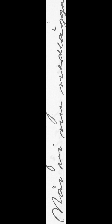

In [12]:
image = Image.open(train_df['file_name'][0]).convert('RGB').transpose(Image.ROTATE_90)
image

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=config.batch_size)

In [14]:
from transformers import VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Tried small then base
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [15]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = config.max_target_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [16]:
from evaluate import load
cer_metric = load("cer", trust_remote_code=True)

In [17]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    _cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return _cer

In [18]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

best_cer = float('inf')  # start with a high CER

for epoch in range(config.num_epochs):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   valid_cer /= len(eval_dataloader)
   print("Validation CER:", valid_cer)

   # save the best model
   if valid_cer < best_cer:
       print("New best model found!")
       best_cer = valid_cer
       model.save_pretrained("./custom_models/trocr_demoktatii_htr/small/v1.0/vision_model/")
       processor.save_pretrained("./custom_models/trocr_demoktatii_htr/small/v1.0/processor/")

wandb.finish()

  0%|          | 0/4225 [00:00<?, ?it/s]

Loss after epoch 0: 2.6505331683582103


  0%|          | 0/1057 [00:00<?, ?it/s]

C:\Users\salim\.conda\envs\ml\lib\site-packages\transformers\generation\utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 110, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.46301556444202135
New best model found!


  0%|          | 0/4225 [00:00<?, ?it/s]

Loss after epoch 1: 1.681456641276207


  0%|          | 0/1057 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 110, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.4180784320143054
New best model found!


  0%|          | 0/4225 [00:00<?, ?it/s]

Loss after epoch 2: 1.3902623108576035


  0%|          | 0/1057 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 110, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.3609664231436961
New best model found!


  0%|          | 0/4225 [00:00<?, ?it/s]

Loss after epoch 3: 1.2049464050905239


  0%|          | 0/1057 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 110, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.3350699741650847
New best model found!


  0%|          | 0/4225 [00:00<?, ?it/s]

Loss after epoch 4: 1.0685175328565066


  0%|          | 0/1057 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 110, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.32585421127818703
New best model found!


  0%|          | 0/4225 [00:00<?, ?it/s]

Loss after epoch 5: 0.9588531437992345


  0%|          | 0/1057 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 110, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.3059973376440361
New best model found!
